In [1]:
from __future__ import print_function
import time
import robobo
import math
import cv2
import sys
import signal
import prey
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from vrep.error import VrepApiError 

Hardware Connection not available in python3 :(


In [2]:
class Agent(robobo.SimulationRobobo):
    def __init__(self, ip='192.168.1.133',
                 port=19997,
                 act_range = (0,40),
                 act_granularity = 10,
                 discount=.95
                 ):
        super().__init__()
        super().connect(address=ip, port=port)
        self.discount = discount
        self.states = []
        self.actions = []
        self.action_dists = []
        self.training_results = {"loss_entropy" : [], "loss" : [], 
                                 "loss_value" : [], "reward" : [], "loss_policy" : []}
        self.min_act = act_range[0]
        self.max_act = act_range[1]
        self.random_policy = lambda state : np.random.randint(self.min_act,
                                                         self.max_act, 2)
        self.hydra = Hydra()
        self.fps = 1000 / act_granularity
        self.act_granularity = act_granularity
    def start_sim(self): return self.play_simulation()
    def end_sim(self): return self.stop_world()
    def pause_sim(self): return self.pause_simulation()
    def mmove(self, action):
        mu_v, var_v, _ = self.net(states_v)
        self.move(r, l, self.act_granularity)
    def run_episode(self, n_steps=1000):
        self.n_steps = n_steps
        self.cumul_reward = 0.
        if self.is_simulation_running():
            self.end_sim()
        try:
            self.episode()
        except VrepApiError:
            self.run_episode(n_steps)
    def episode(self):
        self.cumul_reward = 0.
        print("Initializing simulation")
        self.start_sim()
        print("Starting Episode")
        print(f"FPS = {self.fps}")
        for step in range(self.n_steps):
            self.act()
        print("Closing simulation")
        self.end_sim()
    def get_state(self, use_cam = False,
                  normalize_ir = True,
                 invert_ir = True):
        # to do : edit parent + normalize
        X1 = torch.tensor([[ .2 if not _ else _ for _ in self.read_irs() ]])
        X1 = (X1 - 0.) / (.2 - 0.) if normalize_ir else X1
        X1 = 1 - X1 if invert_ir else X1
        X1 = X1.to(torch.float32)
        # X2 = self.get_image_front()
        if not use_cam:
            self.states.append(X1)
            return X1
        else:
            pass

    def act(self):
        with torch.no_grad():
            state = self.states[-1] if len(self.states) > 0 else self.get_state()
            mu, var, value = self.hydra(state)
            action = torch.distributions.Normal(mu, var).rsample()
            #action = torch.clamp(action, self.min_act, self.max_act)
            #action = torch.clamp(action, min=0, max=100)
            self.actions.append(action)
            r, l,  = action[0][0], action[0][1]
            self.move(r, l, self.act_granularity)
            # observe next state and reward
            next_state = self.get_state()
            reward = - next_state.sum() #state.sum() - next_state.sum()
        
        td_target = reward  #+ self.hydra(next_state)[-1].detach()
        self.optimizer.zero_grad()
        mu, var, value = self.hydra(state)
        # calculate advantage
        advantage = td_target - value.detach()
        # calculate log probs
        p1 = - ((mu - action) ** 2) / (2*var.clamp(min=1e-3))
        p2 = - torch.log(torch.sqrt(2 * math.pi * var))
        log_probs = p1 + p2
        # calculate entropy
        loss_entropy = 1e-4 * (-(torch.log(2*math.pi*var) + 1)/2).mean()
        loss_policy  = (-log_probs * advantage).mean()
        loss_value = ((value-td_target)**2)
        loss = loss_entropy + loss_policy + loss_value
        loss.backward()
        nn.utils.clip_grad_norm_([p for g in self.optimizer.param_groups for p in g["params"]], 1.)
        self.optimizer.step()
        
        
        self.cumul_reward += reward.item()
        self.training_results["loss_entropy"].append(loss_entropy.item())
        self.training_results["loss_policy"].append(loss_policy.item())
        self.training_results["loss_value"].append(loss_value.item())
        self.training_results["reward"].append(reward.item())
        self.training_results["loss"].append(loss.item())

In [3]:
class Hydra(nn.Module):
    def __init__(self, state_dim=8,
                 action_dim=2, latent_dim=16):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(state_dim, latent_dim),
            nn.ReLU())
        self.mu = nn.Sequential(
            nn.Linear(latent_dim, action_dim),
            nn.Tanh()
        )
        self.var = nn.Sequential(
            nn.Linear(latent_dim, action_dim),
            nn.Softplus())
        self.value = nn.Sequential(
            nn.Linear(latent_dim, latent_dim//2),
            nn.ReLU(),
            nn.Linear(latent_dim//2, 1))
        
    def forward(self, x):
        latents = self.encoder(x)
        mu = self.mu(latents) #* 100
        var = self.var(latents)
        value = self.value(latents)
        return mu, var, value


In [4]:
def calc_logprob(mu_v, var_v, actions_v):
    p1 = - ((mu_v - actions_v) ** 2) / (2*var_v.clamp(min=1e-3))
    p2 = - torch.log(torch.sqrt(2 * math.pi * var_v))
    return p1 + p2

In [108]:
try:
    player = Agent()
except:
    player.disconnect()
    player = Agent()
player.hydra = Hydra()
player.optimizer = optim.Adam(player.hydra.parameters(), lr=0.0005)
player.training_results = {"loss_value" : [], "reward" : [], "loss_policy" : []}
player.start_sim()

Connected to remote API server: client id 0


In [118]:
for i in range(100):
    with torch.autograd.detect_anomaly():
        state_ = player.get_state().clone() 
        mu_v, var_v, value_v  = player.hydra(state_)
        mu = mu_v.data.cpu().numpy()
        sigma = torch.sqrt(var_v).data.cpu().numpy()
        action = np.random.normal(mu, sigma)
        action = np.clip(action, -1, 1)
        player.move(action[0][0]*100, action[0][1]*100, 10)
        action = torch.Tensor(action)
        next_state = player.get_state()
        reward = - next_state.sum()

        player.optimizer.zero_grad()
        with torch.no_grad():
            td_target = reward + player.hydra(next_state)[-1]
            td = td_target - value_v
            td = td.detach()
            td_target = td_target.detach()
        loss_value_v = F.mse_loss(value_v, td_target)
        #loss_value_v.backward()
        #player.optimizer.step()
        #log_prob_v = calc_logprob(mu_v, var_v, action)
        log_prob_v = torch.distributions.Normal(mu_v, var_v).log_prob(action)
        loss_policy_v = td * log_prob_v.mean()
        loss_policy_v.backward()
        player.optimizer.step()
        player.training_results["loss_policy"].append(loss_policy_v.item())
        player.training_results["loss_value"].append(loss_value_v.item())
        player.training_results["reward"].append(reward.item())

/tmp/ipykernel_140952/3577729628.py:2: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


KeyboardInterrupt: 

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

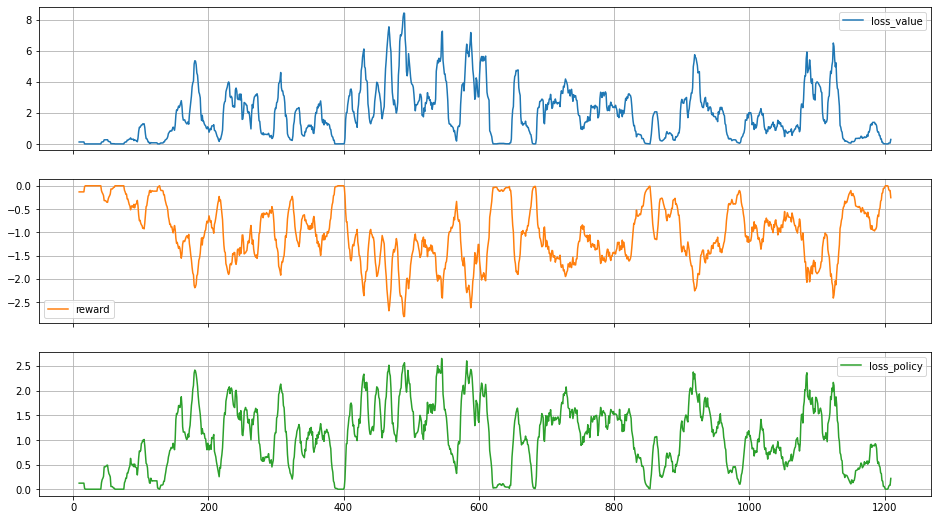

In [117]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16,9)
pd.DataFrame(player.training_results).rolling(10).mean().plot(subplots=True,grid=True)

In [153]:
try:
    player = Agent()
except:
    player.disconnect()
    player = Agent()
player.hydra = Hydra()
player.optimizer = optim.Adam(player.hydra.parameters(), lr=0.0001)
player.memory = {"loss_value" : [], "reward" : [], "loss_policy" : [], "states" : [], "actions" : []}
player.start_sim()

Connected to remote API server: client id 0


In [159]:
player.start_sim()

In [163]:
player.move(13,10,5000)

In [157]:
for i in range(1000):
    with torch.autograd.detect_anomaly():
        state_ = player.get_state().clone()
        mu_, var_, value_  = player.hydra(state_)
        mu = mu_.data.cpu().numpy()
        sigma = torch.sqrt(var_).data.cpu().numpy()
        action = np.random.normal(mu, sigma)
        action = np.clip(action, -1, 1)
        player.move(action[0][0]*100, action[0][1]*100, 500)
        action = torch.Tensor(action)
        next_state = player.get_state()
        reward = next_state.sum() * -100.

        player.optimizer.zero_grad()
        mu_v, var_v, value_v = player.hydra(state_)

        #loss_value_v = F.mse_loss(value_v.squeeze(-1), reward.unsqueeze(-1))
        loss_value_v = F.smooth_l1_loss(value_v.squeeze(-1), reward.unsqueeze(-1))
        adv_v = reward.unsqueeze(dim=-1) - value_v.detach()
        #log_prob_v = adv_v * calc_logprob(mu_v, var_v, action)
        log_prob_v = adv_v * torch.distributions.Normal(mu_v, var_v).log_prob(action)
        loss_policy_v = -log_prob_v.mean()
        entropy_loss_v = 0.0001 * (-(torch.log(2*math.pi*var_v) + 1)/2).mean()
        loss_v = loss_policy_v + loss_value_v + entropy_loss_v
        loss_v.backward()
        player.optimizer.step()
        player.memory["loss_policy"].append(loss_policy_v.item())
        player.memory["loss_value"].append(loss_value_v.item())
        player.memory["reward"].append(reward.item())
        player.memory["states"].append(state_.detach())
        player.memory["actions"].append(action.detach())

/tmp/ipykernel_140952/2114097614.py:2: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


KeyboardInterrupt: 

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

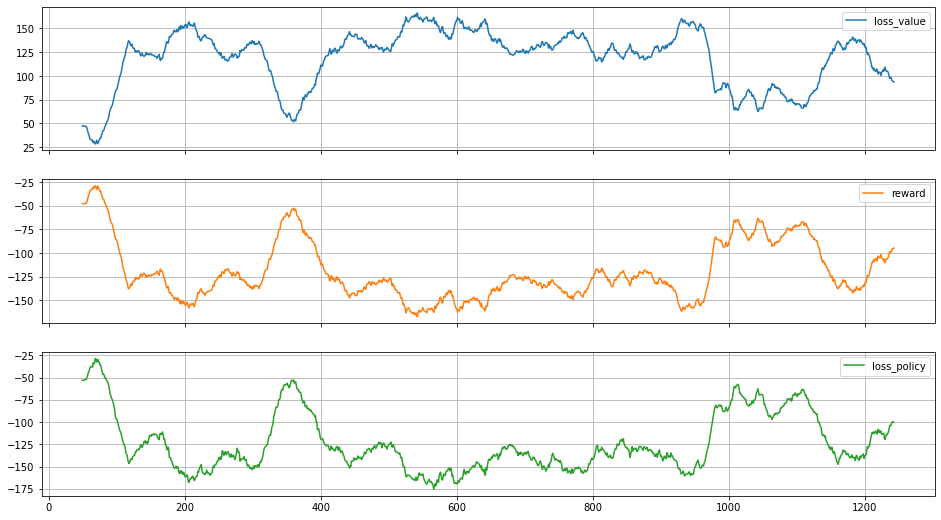

In [158]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16,9)
pd.DataFrame({_ : player.memory[_] for _ in player.memory if _ not in ["states", "actions"]}).rolling(50).mean().plot(subplots=True,grid=True)

In [251]:

with torch.autograd.detect_anomaly():
    state_ = player.get_state().clone()
    mu_, var_, value_  = player.hydra(state_)
    mu = mu_.data.cpu().numpy()
    sigma = torch.sqrt(var_).data.cpu().numpy()
    action = np.random.normal(mu, sigma)
    action = np.clip(action, -1, 1)
    player.move(action[0][0]*100, action[0][1]*100, 10)
    action = torch.Tensor(action)
    next_state = player.get_state()
    reward = - next_state.sum()

    player.optimizer.zero_grad()
    mu_v, var_v, value_v = player.hydra(state_)

    loss_value_v = F.mse_loss(value_v.squeeze(-1), reward.unsqueeze(-1))

    adv_v = reward.unsqueeze(dim=-1) - value_v.detach()
    log_prob_v = adv_v * calc_logprob(mu_v, var_v, action)
    loss_policy_v = -log_prob_v.mean()
    entropy_loss_v = 0.001 * (-(torch.log(2*math.pi*var_v) + 1)/2).mean()
    loss_v = loss_policy_v + loss_value_v + entropy_loss_v
    loss_v.backward()
    player.optimizer.step()
    #print(reward.item())
    print(loss_policy_v.item())

-0.921457827091217


/tmp/ipykernel_92731/1490671474.py:1: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


In [29]:
for i in range(10000): 
    with torch.autograd.detect_anomaly():
        player.optimizer.zero_grad()
        state_ = player.get_state().clone()
        mu_, var_, value_  = player.hydra(state_)
        mu = mu_.data.cpu().numpy()
        sigma = torch.sqrt(var_).data.cpu().numpy()
        action = np.random.normal(mu, sigma)
        action = np.clip(action, -1, 1)
        player.move(action[0][0]*100, action[0][1]*100, player.act_granularity)
        action = torch.Tensor(action)
        next_state = player.get_state()
        #punish rotation !
        l = action[0][0] * 100
        r = action[0][1] * 100
        speed_reward = abs(abs(l) + abs(r))
        
        reward = state_.sum() - next_state.sum() 
        #reward = (action.sum() - rotation_penalty)
        reward = -speed_reward
        print(reward)
        player.optimizer.zero_grad()
        mu_v, var_v, value_v = player.hydra(state_)

        loss_value_v = F.mse_loss(value_v.squeeze(-1), reward.unsqueeze(-1))

        adv_v = reward.unsqueeze(dim=-1) - value_v.detach()
        log_prob_v = adv_v * calc_logprob(mu_v, var_v, action)
        loss_policy_v = -log_prob_v.mean()
        entropy_loss_v = 0.001 * (-(torch.log(2*math.pi*var_v) + 1)/2).mean()
        loss_v = loss_policy_v + loss_value_v + entropy_loss_v
        loss_v.backward()
        player.optimizer.step()

/tmp/ipykernel_32645/1458678867.py:2: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


tensor(-78.5003)
tensor(-200.)
tensor(-73.1454)
tensor(-107.5293)
tensor(-47.8335)
tensor(-62.8225)
tensor(-101.8810)
tensor(-66.9517)
tensor(-121.3892)
tensor(-73.4817)
tensor(-18.0458)
tensor(-155.1097)
tensor(-8.9811)
tensor(-67.2414)
tensor(-123.1212)
tensor(-173.2708)
tensor(-105.6180)
tensor(-167.8183)
tensor(-40.1685)
tensor(-72.6538)
tensor(-106.1894)
tensor(-101.4259)
tensor(-166.5801)
tensor(-142.0083)
tensor(-113.8979)
tensor(-114.1430)
tensor(-76.6615)
tensor(-108.3655)
tensor(-120.5783)
tensor(-126.5071)
tensor(-101.8395)
tensor(-87.8350)
tensor(-83.9115)
tensor(-70.0145)
tensor(-111.9719)
tensor(-59.3001)
tensor(-174.1305)
tensor(-126.0633)
tensor(-140.4076)
tensor(-145.3692)
tensor(-167.5621)
tensor(-193.2482)
tensor(-106.9535)
tensor(-86.1694)
tensor(-76.8272)
tensor(-159.1841)
tensor(-45.1961)
tensor(-44.2114)
tensor(-200.)
tensor(-156.6478)
tensor(-48.4771)
tensor(-50.9636)
tensor(-188.6212)
tensor(-168.0641)
tensor(-87.2949)
tensor(-32.5113)
tensor(-200.)
tensor(-200

KeyboardInterrupt: 

In [22]:
player.hydra(state_)

(tensor([[nan, nan]], grad_fn=<TanhBackward0>),
 tensor([[nan, nan]], grad_fn=<SoftplusBackward0>),
 tensor([[nan]], grad_fn=<AddmmBackward0>))

In [18]:
mu_, var_, value_ 

(tensor([[nan, nan]], grad_fn=<TanhBackward0>),
 tensor([[nan, nan]], grad_fn=<SoftplusBackward0>),
 tensor([[nan]], grad_fn=<AddmmBackward0>))

In [50]:
player.hydra(player.get_state())

(tensor([[ 0.0640, -0.1842]], grad_fn=<TanhBackward0>),
 tensor([[0.6848, 0.7987]], grad_fn=<SoftplusBackward0>),
 tensor([[-0.0651]], grad_fn=<AddmmBackward0>))

In [57]:
n_steps = 10
for step in range(n_steps):
    state_ = player.get_state().clone()
    mu_, var_, value_  = player.hydra(state_)
    mu = mu_.data.cpu().numpy()
    sigma = torch.sqrt(var_).data.cpu().numpy()
    action = np.random.normal(mu, sigma)
    action = np.clip(action, -1, 1)
    player.move(action[0][0]*100, action[0][1]*100, player.act_granularity)
    action = torch.Tensor(action)
    next_state = player.get_state()
    reward = state_.sum() / next_state.sum()

    player.optimizer.zero_grad()
    mu_v, var_v, value_v = player.hydra(state_)

    loss_value_v = F.mse_loss(value_v.squeeze(-1), reward.unsqueeze(-1))

    adv_v = reward.unsqueeze(dim=-1) - value_v.detach()
    log_prob_v = adv_v * calc_logprob(mu_v, var_v, action)
    loss_policy_v = -log_prob_v.mean()
    entropy_loss_v = 0.001 * (-(torch.log(2*math.pi*var_v) + 1)/2).mean()

    loss_v = loss_policy_v + entropy_loss_v + loss_value_v
    loss_v.backward()
    player.optimizer.step()

In [ ]:
player = Agent()

In [ ]:
player.run_episode(32)

In [7]:
player.end_sim()
player.disconnect()

In [13]:
player.actor.log_scale

Parameter containing:
tensor([5., 5.], requires_grad=True)

In [ ]:

player.act()
player.actions[-1]

In [ ]:
player.start_sim()
player.act()

In [ ]:
player.states

In [14]:
list(player.hydra.encoder.modules())[0][0].weight.grad.sum()

tensor(-2.8738)

In [8]:
list(player.hydra.mu.modules())[0][0].weight

Parameter containing:
tensor([[ 0.5396, -0.1553,  0.4454,  0.6327, -0.1445, -0.1711, -0.0179,  0.8665,
          0.5346,  0.8602, -0.1579, -0.0574,  0.7988,  0.6809,  0.7308,  0.6371,
          0.6056,  0.1000,  0.1510, -0.0181,  0.2670,  0.8208,  0.8598,  0.3105,
          0.5589,  0.1131, -0.1526,  0.7072,  0.3142, -0.2229, -0.0271,  0.8265],
        [ 0.3700,  0.0583,  0.6086,  0.5995, -0.0514,  0.0697, -0.1668,  0.5978,
          0.5798,  0.6429, -0.1359,  0.1549,  0.5488,  0.6706,  0.8709,  0.7929,
          0.7289, -0.0303, -0.0702,  0.0758,  0.3124,  0.8690,  0.6392,  0.2983,
          0.7397,  0.2514, -0.1555,  0.7787,  0.2485, -0.0086,  0.0712,  0.8420]],
       requires_grad=True)

In [18]:
player.hydra.value.weight.grad

tensor([[0.0000, 0.1556, 0.1754, 0.1419, 0.1292, 0.1401, 0.1480, 0.1170, 0.1760,
         0.1434, 0.0000, 0.1742, 0.1554, 0.1626, 0.1712, 0.0000, 0.1665, 0.1642,
         0.0000, 0.1750, 0.1556, 0.0000, 0.1829, 0.1290, 0.1507, 0.1589, 0.1811,
         0.1658, 0.1437, 0.1794, 0.1316, 0.0000]])

In [11]:
player.hydra.value.weight.grad.sum()

tensor(1.8862e+09)

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>], dtype=object)

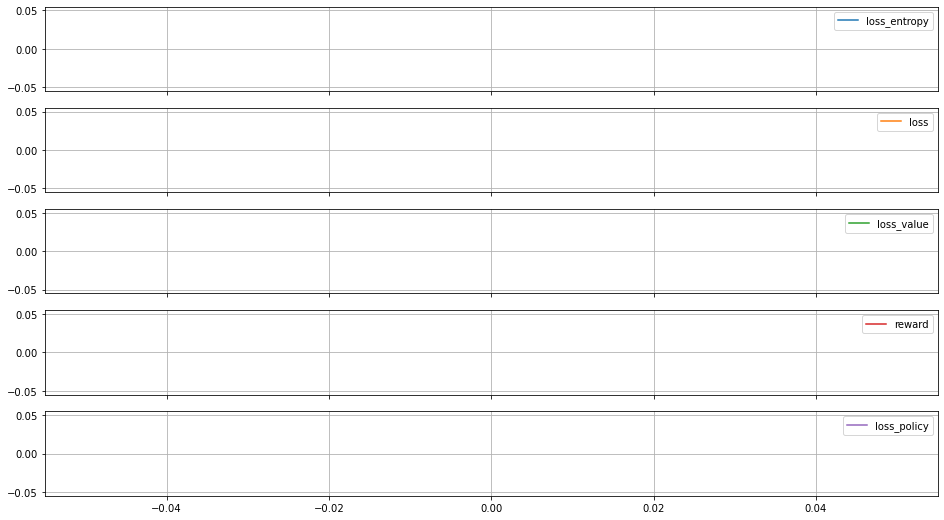

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16,9)
pd.DataFrame(player.training_results).plot(subplots=True,grid=True)

In [7]:
player.end_sim()

In [17]:
player.states

[tensor([[0., 0., 0., 0., 0., 0., 0., 0.]]),
 tensor([[0., 0., 0., 0., 0., 0., 0., 0.]]),
 tensor([[0., 0., 0., 0., 0., 0., 0., 0.]]),
 tensor([[0., 0., 0., 0., 0., 0., 0., 0.]]),
 tensor([[0., 0., 0., 0., 0., 0., 0., 0.]]),
 tensor([[0., 0., 0., 0., 0., 0., 0., 0.]]),
 tensor([[0., 0., 0., 0., 0., 0., 0., 0.]]),
 tensor([[0., 0., 0., 0., 0., 0., 0., 0.]]),
 tensor([[0., 0., 0., 0., 0., 0., 0., 0.]]),
 tensor([[0., 0., 0., 0., 0., 0., 0., 0.]]),
 tensor([[0.0000, 0.0558, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]]),
 tensor([[0., 0., 0., 0., 0., 0., 0., 0.]]),
 tensor([[0., 0., 0., 0., 0., 0., 0., 0.]]),
 tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0369, 0.0000]]),
 tensor([[0.0114, 0.0793, 0.0000, 0.0000, 0.0000, 0.0000, 0.1569, 0.0582]]),
 tensor([[0.0281, 0.0988, 0.0140, 0.0000, 0.0000, 0.0000, 0.2397, 0.1748]]),
 tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2096, 0.2907]]),
 tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1603, 0.4126]])

In [7]:
player.act(True)

TypeError: act() takes 1 positional argument but 2 were given

In [9]:
player.end_sim()

In [9]:
player.pause_sim()

In [7]:
player.start_sim()

In [13]:
##useful methods

rob.get_sim_time()

rob.get_image_front()

rob.read_irs()

rob.move()

rob.pause_simulation()

rob.stop_world()


469754